<a href="https://colab.research.google.com/github/xarvel/DataScience/blob/master/ResNet_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  %tensorflow_version 2.x 
except Exception:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform

In [4]:
#@title Config
normalize_dataset = True

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
y_train_onehot = to_categorical(y_train, num_classes=None, dtype='float32')
print("Train Set Size = {} images".format(y_train.shape[0]))
print("Test Set Size = {} images".format(y_test.shape[0]))
if normalize_dataset:
  x_train = (x_train.astype(np.float32) - 127.5) / 127.5
  x_test = (x_test.astype(np.float32) - 127.5) / 127.5

11490434/11490434 [==============================] - 1s 0us/step
Train Set Size = 60000 images
Test Set Size = 10000 images


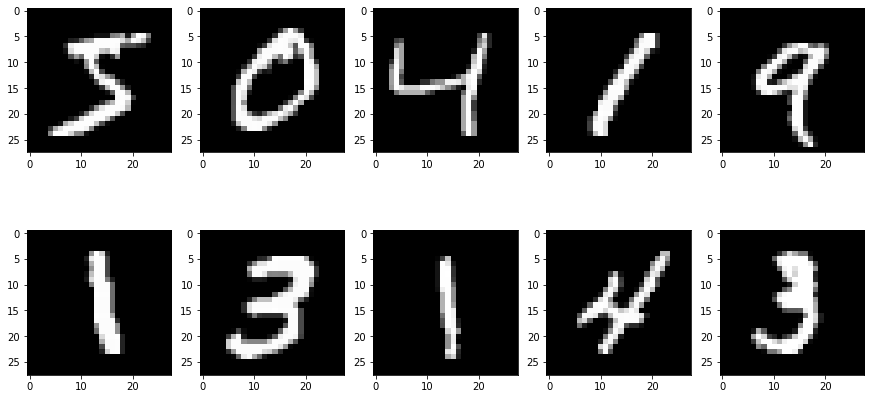

Labels : [5 0 4 1 9]
Labels : [1 3 1 4 3]


In [6]:
fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(x_train[i], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(x_train[i+6], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("Labels : {}".format(y_train[0:5]))
print("Labels : {}".format(y_train[6:11]))

In [7]:
optimizer = 'adam'
objective = 'categorical_crossentropy'

def residual_block(X, f, filters, stride=2, conv_shortcut=True):
    F1, F2, F3 = filters

    if conv_shortcut is True:
        X_shortcut = Conv2D(F3, kernel_size=(1,1), strides=(stride,stride), kernel_initializer=glorot_uniform(seed=0))(X)
        X_shortcut = BatchNormalization(axis=3)(X_shortcut)
    else:
        X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(stride,stride), padding='valid', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='valid', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


def stack(X, filters, blocks, stride1=2):
    X = residual_block(X, 3, filters = filters, stride = stride1, conv_shortcut=True)

    for i in range(2, blocks + 1):
        X = residual_block(X, 3, filters = filters, stride = 1, conv_shortcut=False)
    return X


def create_resnet_model():
    
    # Define the input as a tensor with shape input_shape
    X_input = Input((28, 28, 1))
    
    # Zero-Padding
    # X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2))(X_input)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
    #X = ZeroPadding2D(padding=((1, 1), (1, 1)), name='pool1_pad')(x)
    #X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    X = stack(X, filters = [32, 32, 64], blocks = 3, stride1 = 1)

    # Stage 2
    # X = stack(X, filters = [64, 64, 256], blocks = 3, stride1 = 1)
    # # Stage 3
    # X = stack(X, filters = [128, 128, 512], blocks = 5, stride1 = 2)
    # # Stage 4
    # X = stack(X, filters = [256, 256, 1024], blocks = 5, stride1 = 2)
    # # Stage 5
    # X = stack(X, filters = [512, 512, 2048], blocks = 3, stride1 = 2)
    
    # AVGPOOL
    # X = AveragePooling2D((2,2), name='avg_pool')(X)
    
    # output layer
    X = Flatten()(X)
    X = Dense(y_train_onehot.shape[1], activation='softmax', name='fc' + str(y_train_onehot.shape[1]))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')
    
    #Compile the model
    model.compile(optimizer=optimizer, loss=objective, metrics=['accuracy'])
    
    return model

In [8]:
model = create_resnet_model()

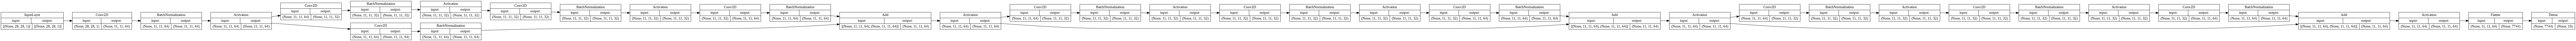

In [9]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, rankdir='LR')

In [10]:
nb_epoch = 10
batch_size = 128

history = model.fit(
        x_train.reshape((-1,28,28,1)), 
        y_train_onehot, 
        batch_size=batch_size, 
        epochs=nb_epoch,
        validation_split=0.25, 
        verbose=1, 
        shuffle=True)

Epoch 1/10
352/352 [==============================] - 16s 15ms/step - loss: 0.2744 - accuracy: 0.9308 - val_loss: 0.0807 - val_accuracy: 0.9754
Epoch 2/10
352/352 [==============================] - 4s 12ms/step - loss: 0.0648 - accuracy: 0.9813 - val_loss: 0.1032 - val_accuracy: 0.9736
Epoch 3/10
352/352 [==============================] - 4s 12ms/step - loss: 0.0529 - accuracy: 0.9852 - val_loss: 0.1472 - val_accuracy: 0.9695
Epoch 4/10
352/352 [==============================] - 4s 12ms/step - loss: 0.0402 - accuracy: 0.9882 - val_loss: 0.0888 - val_accuracy: 0.9804
Epoch 5/10
352/352 [==============================] - 4s 12ms/step - loss: 0.0313 - accuracy: 0.9906 - val_loss: 0.0736 - val_accuracy: 0.9835
Epoch 6/10
352/352 [==============================] - 4s 12ms/step - loss: 0.0344 - accuracy: 0.9903 - val_loss: 0.0921 - val_accuracy: 0.9801
Epoch 7/10
352/352 [==============================] - 4s 12ms/step - loss: 0.0280 - accuracy: 0.9916 - val_loss: 0.0869 - val_accuracy: 0.983

In [11]:
#print(model.summary())
predictions = model.predict(x_test.reshape((-1,28,28,1)), verbose=0)

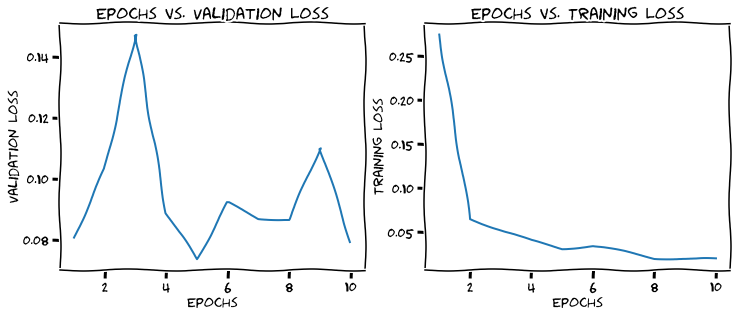

In [15]:
with plt.xkcd():
  fig1 = plt.figure(figsize = (12,10))
  ax1 = fig1.add_subplot(2,2,1)
  ax2 = fig1.add_subplot(2,2,2)

  ax1.plot(np.arange(1,nb_epoch+1), history.history['val_loss'])
  ax1.set(xlabel='Epochs', ylabel='Validation Loss',
        title='Epochs vs. Validation Loss')
  ax2.plot(np.arange(1,nb_epoch+1), history.history['loss'])
  ax2.set(xlabel='Epochs', ylabel='Training Loss',
        title='Epochs vs. Training Loss')
  plt.show()

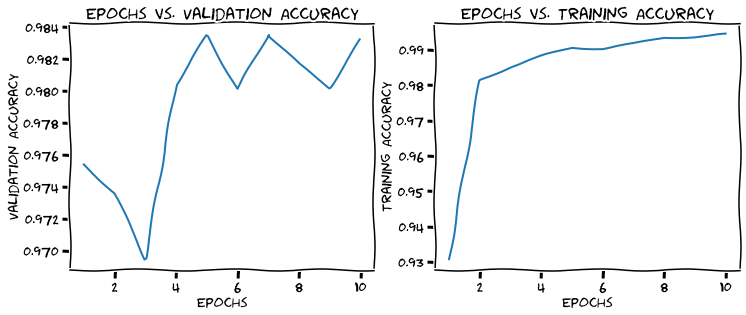

In [16]:
with plt.xkcd():
  fig1 = plt.figure(figsize = (12,10))
  ax1 = fig1.add_subplot(2,2,1)
  ax2 = fig1.add_subplot(2,2,2)

  ax1.plot(np.arange(1,nb_epoch+1), history.history['val_accuracy'])
  ax1.set(xlabel='Epochs', ylabel='Validation Accuracy',
        title='Epochs vs. Validation Accuracy')
  ax2.plot(np.arange(1,nb_epoch+1), history.history['accuracy'])
  ax2.set(xlabel='Epochs', ylabel='Training Accuracy',
        title='Epochs vs. Training Accuracy')
  plt.show()

Test accuracy: 98.6 %


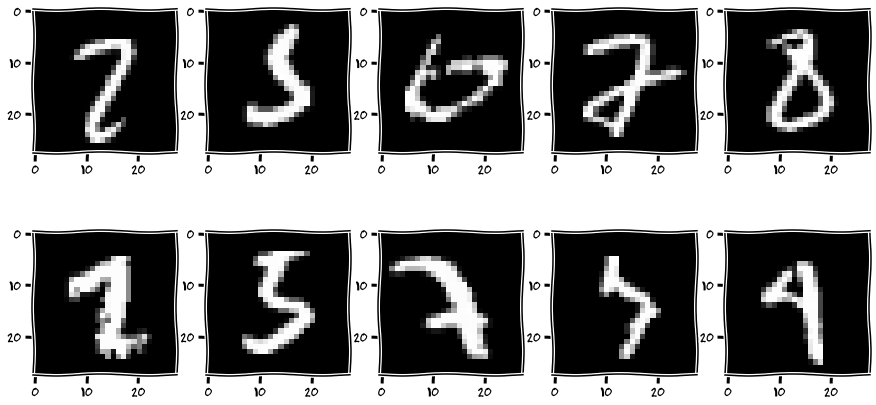

True:          [2 5 6 2 8]
classified as: [7 3 0 7 3]
True:          [2 5 7 7 4]
classified as: [3 3 3 3 9]


In [17]:
def test_accuracy():
    err = []
    t = 0
    for i in range(predictions.shape[0]):
        if (np.argmax(predictions[i]) == y_test[i]):
            t = t+1
        else:
            err.append(i)
    return t, float(t)*100/predictions.shape[0], err

p = test_accuracy()
print("Test accuracy: {} %".format(p[1]))

with plt.xkcd():
  fig1 = plt.figure(figsize = (15,15))

  for i in range(5):
      ax1 = fig1.add_subplot(1,5,i+1) 
      ax1.imshow(x_test[p[2][i]], interpolation='none', cmap=plt.cm.gray)
      ax2 = fig1.add_subplot(2,5,i+6) 
      ax2.imshow(x_test[p[2][i+6]], interpolation='none', cmap=plt.cm.gray)
  plt.show()

print("True:          {}".format(y_test[p[2][0:5]]))
print("classified as: {}".format(np.argmax(predictions[p[2][0:5]], axis=1)))

print("True:          {}".format(y_test[p[2][6:11]]))
print("classified as: {}".format(np.argmax(predictions[p[2][6:11]], axis=1)))